In [43]:
### Global Configuration ###

# K-NN factor (from paper, 
#   the best experiemented value 
#   ranges from 20 to 50)
K=50

# top N
TN = 5


In [44]:

### Load Data ###
import pandas as pd
import numpy as np


movie_genres_csv_path = "./data/movie_genres.csv"
user_reviews_csv_path = "./data/user_reviews.csv"

movie_genres = pd.read_csv(movie_genres_csv_path)
user_reviews = pd.read_csv(user_reviews_csv_path)

# remove first (id) and second cols (movie name)
movie_name = movie_genres.iloc[:,1]
movie_genres = movie_genres.iloc[:,2:] # id and movie name 

user_name = user_reviews.iloc[:,1]
user_reviews = user_reviews.iloc[:,2:] # id and user name

# convert into np format 
movie_genres = movie_genres.values
user_reviews = user_reviews.values

# for debug
print(movie_genres.shape)
print(user_reviews.shape)
print(movie_name.values[0:10])
print(user_name.values[0:10])

(2000, 25)
(600, 2000)
['The Net' "Happily N'Ever After" 'Tomorrowland' 'American Hero'
 'Das Boot' 'Final Destination 3' 'Licence to Kill'
 'The Hundred-Foot Journey' 'The Matrix' 'Creature']
['Vincent' 'Edgar' 'Addilyn' 'Marlee' 'Javier' 'Marcus' 'Mary' 'Rosalie'
 'Giovanni' 'Kennedi']


In [45]:
### Do KNN for all movies ###
from sklearn.neighbors import NearestNeighbors

# using hamming distance (no specific method in paper)
knn_model = NearestNeighbors(n_neighbors=K, metric='hamming')

# training the module
knn_model.fit(movie_genres)

def compute_k_neightbors(user_idx,movie_idx):
  query_movie  = movie_genres[movie_idx]
  distances, indices = knn_model.kneighbors([query_movie])

  user_review_i = user_reviews[user_idx]
  N_u_i = []
  for i in indices.flatten():
      if user_review_i[i] != 0.0 and i != movie_idx:
          N_u_i.append(i)
  return N_u_i

In [46]:
###### test module with the first data ######
idx = 0
query_movie  = movie_genres[idx]

distances, indices = knn_model.kneighbors([query_movie])

print ("distance:\n",distances)
print ("indices:\n", indices)

print("idx '%d' is movie: %s"%(idx, movie_name[idx]))
print("\n\t", query_movie)
print("Similar movies:")
for i in indices.flatten():
    print("\t", movie_name[i])
    print("\t", movie_genres[i])

# still for the first user, select the neighborhood movies she/he rated from the all
# similar movies selected by KNN.
user_idx = 0
user_review_i = user_reviews[user_idx]
N_u_i = []
for i in indices.flatten():
    if user_review_i[i] != 0.0:
        N_u_i.append(i)
        
print(N_u_i)

print(compute_k_neightbors(0,0))
# might be a challenging:
#   a specific user might have just rated very little movies.

###### test end ######


distance:
 [[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.04
  0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
  0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
  0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]]
indices:
 [[   0  835 1880 1587  479  986  229 1014  832  539 1568  285  798 1542
   918  427 1918  554 1147 1148  760 1802 1627 1678 1187 1132 1754  129
  1241 1333 1961   79 1140 1430  558 1037 1864  150 1057 1821 1408  588
   160  499   97 1096 1294  452 1407  253]]
idx '0' is movie: The Net

	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
Similar movies:
	 The Net
	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
	 Max Payne
	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
	 Enemy of the State
	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
	 Street Fighter: The Legend of Chun-Li
	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
	 Broken Horses
	 [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 

In [47]:
### Compute bias rating (b) ###

def predict_b(user_idx, movie_idx = None):
  """
  according to the paper, here using the mean rating of user u
  as b.
  """
  # movie_idx is not used in this method.
  user_ratings = user_reviews[user_idx]
  non_zero_ratings = user_ratings[user_ratings !=0 ]
  b = np.mean(non_zero_ratings)
  return b

###### test  ######
user_idx = 0
b = predict_b(user_idx, None)
print("For user %d, b is :%f" % (user_idx, b))
###### test end ######

For user 0, b is :3.820513


In [48]:
### Compute Similarity (s) ###

def estimate_similarity_m1(movie_idx_i, movie_idx_j):
  """
    Pearson correlation coefficient.
  """
  vector1 = movie_genres[movie_idx_i]
  vector2 = movie_genres[movie_idx_j]
  # print(vector1)
  # print(vector2)
  # Calculate the Pearson correlation coefficient
  correlation_coefficient = np.corrcoef(vector1, vector2)[0, 1]
  return correlation_coefficient

###### test  ######
s_i_j = estimate_similarity_m1(0,835)
print("similarity 'Pearson correlation' is: %f" % s_i_j)

s_i_j = estimate_similarity_m1(0,253)
print("similarity 'Pearson correlation' is: %f" % s_i_j)

###### test end ######

similarity 'Pearson correlation' is: 1.000000
similarity 'Pearson correlation' is: 0.872872


In [49]:
### Compute estimated rating for all movies for the each of the first five persons ###
def standard_NN_model(user_idx, movie_idx):
  # r_ui = b_ui + (sum s_ij * (r_uj - b_uj))/(sum s_ij)
  b_ui = predict_b(user_idx, movie_idx)

  Ns = compute_k_neightbors(user_idx, movie_idx)
  
  r_ui = b_ui

  sum_up = 0.0

  sum_down = 0.0

  for j in Ns:
    s_ij = estimate_similarity_m1(movie_idx,j)
    sum_up += s_ij * (user_reviews[user_idx][j] - predict_b(user_idx,j))
    sum_down += s_ij
  
  # !!! @todo how to cope with zero neighbor
  if sum_down !=0.0:
    r_ui += sum_up/sum_down

  return r_ui, \
         Ns # for debug 

# in this step we finish our basic recommodation system.
# we can do the predict and then check their preference by ourself 
# (show the history distribution of each person)

def recommand(user_idx):
  # select those unwatched movies
  reviews = user_reviews[user_idx]
  unwatched_idx_arr = np.where(reviews == 0)[0]
  # print("reviews:", reviews)
  # print("unwatched_idx_arr:", unwatched_idx_arr)
  # estimate the ratings
  estimated_ratings = []
  Ns_num  = []
  for movie_idx in unwatched_idx_arr:
    # print("movie_idx:", movie_idx)
    r_ui, Ns = standard_NN_model(user_idx,movie_idx)
    estimated_ratings.append(r_ui)
    Ns_num.append(len(Ns))
  
  # find the top N estimated ratings idx
  top_N_indices = np.argsort(estimated_ratings)[-TN:]

  top_N_movies_indice = []
  ratings = []
  # map to the movies idx 
  for i in top_N_indices:
    top_N_movies_indice.append(unwatched_idx_arr[i])
    ratings.append(estimated_ratings[i])
  
  return top_N_movies_indice, ratings, \
         estimated_ratings, Ns_num # debug


In [50]:
def print_user_info(user_id):
    user_ratings = user_reviews[user_id]
    non_zero_ratings = user_ratings[user_ratings !=0 ]
    average_rating = np.mean(non_zero_ratings)
    max_rating = np.max(non_zero_ratings)
    min_rating = np.min(non_zero_ratings)

    print("user:%s, average_rating = %f, max rating %f, min rating %f"% 
      (user_name[user_id], average_rating, max_rating,min_rating ))
    
    rated_top_5_idx = np.argsort(user_ratings)[-5:]
    print("rated_top_5:")
    for idx in rated_top_5_idx:
      print("\t%.1f %40s %s" % (user_ratings[idx], movie_name[idx], movie_genres[idx]))

### recommond with standard NN module ###
ratings_list = []
Ns_num_list = []
for user_id in range(5):
  u_tN, ratings, all_ratings, Ns = recommand(user_id)
  # save all estimated ratings to do analyse
  ratings_list.append(all_ratings) 
  Ns_num_list.append(Ns)
  print_user_info(user_id)
  print("recommond:")
  for i in range(len(u_tN)):
    print("\t%.1f %40s %s" % (ratings[i], 
                               movie_name[u_tN[i]][0: min(len(movie_name[u_tN[i]]),40)],
                               movie_genres[u_tN[i]]))

  print("")

user:Vincent, average_rating = 3.820513, max rating 5.000000, min rating 1.000000
rated_top_5:
	5.0          The Importance of Being Earnest [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
	5.0                                 Superman [1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
	5.0           Dawn of the Planet of the Apes [1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
	5.0                               Stone Cold [1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
	5.0        The Dangerous Lives of Altar Boys [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
recommond:
	5.0                                     Prom [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	5.0                   The American President [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
	5.0                      Theresa Is a Mother [0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
	5.0                              Ghost World [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
	5.0        

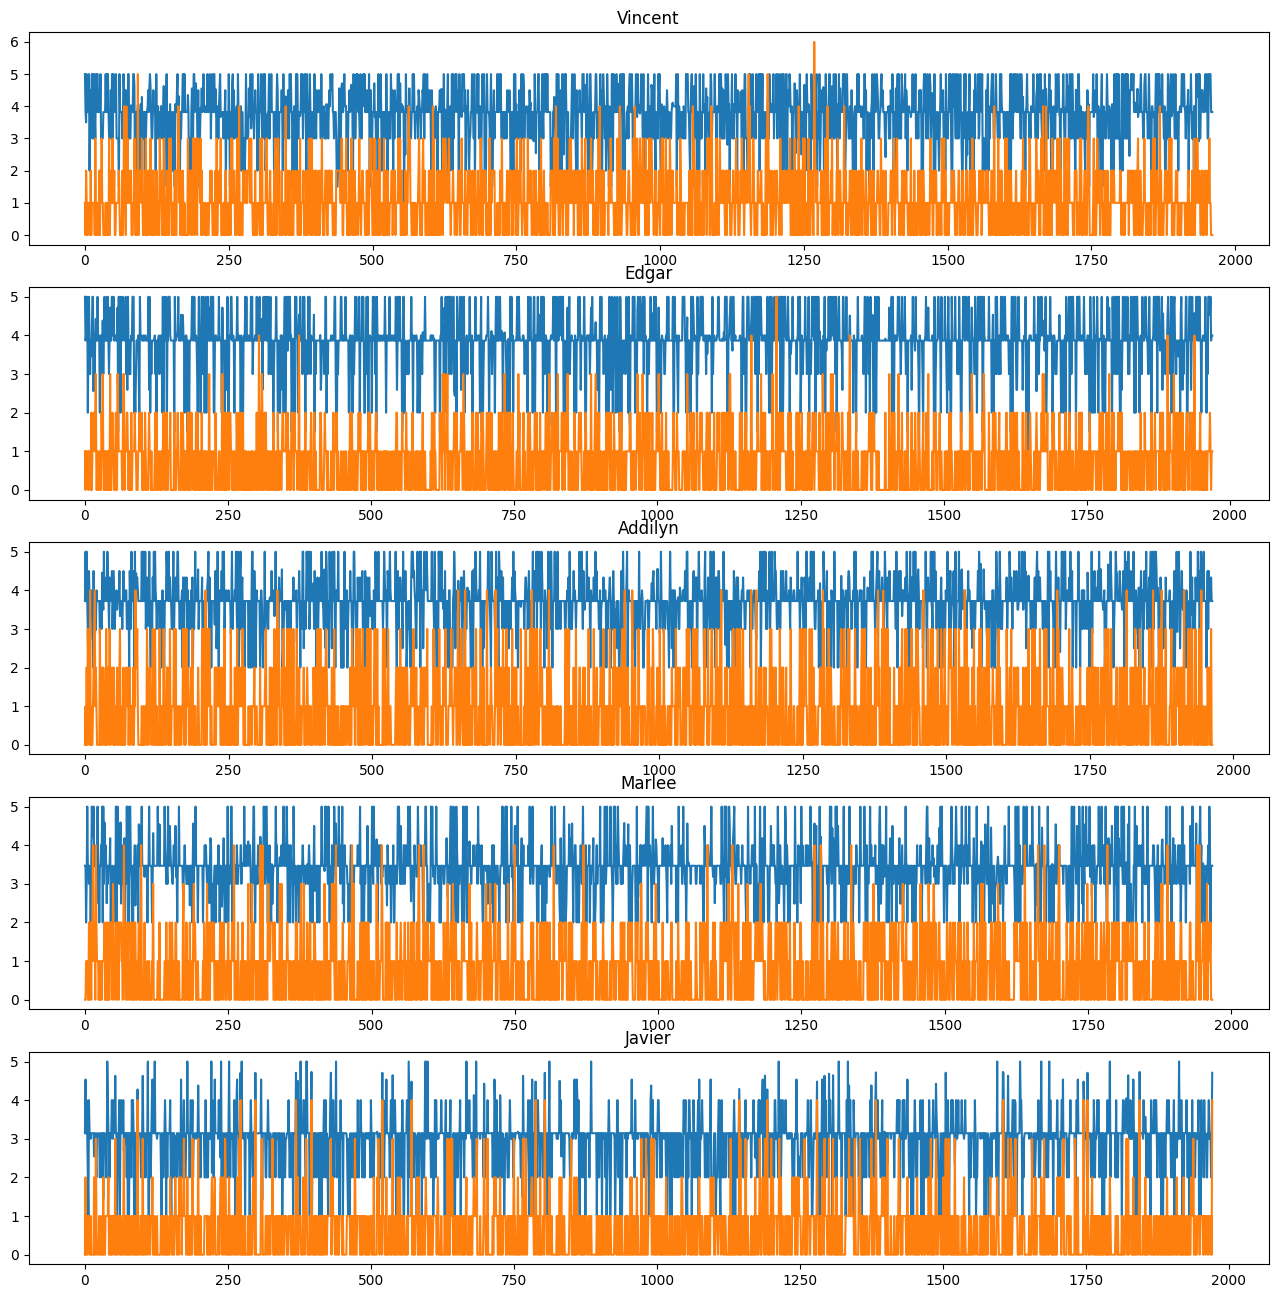

In [55]:
### Analyse standard NN method result ###
import matplotlib.pyplot as plt

fig,axs= plt.subplots(5, 1, figsize=(16, 16))
axs = axs.flatten()
for j in range(len(ratings_list)):
    ax = axs[j]
    ax.plot([i for i in range(len(ratings_list[j]))],ratings_list[j] )
    ax.plot([i for i in range(len(Ns_num_list[j]))],Ns_num_list[j] )
    ax.set_title(user_name[j])
    
### Analyse end ###

In [52]:
### integrate local veiw to improve ###
